# Random Forests

### Load Requirements

In [2]:
%load_ext autoreload
%autoreload

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data_utils import get_training, get_testing, HEADER
from sklearn.ensemble import RandomForestClassifier as Forest

from validation import Validation

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from my_pca import my_pca

%matplotlib notebook

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Random Forests - finding best PCA Component

In [4]:
X, y = get_training()
val = Validation(X, y, k = 5, bootstrap=-1)

pca_comp = [3,5,9,11,13,15,20,25,30]

pca_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}

bsf = (0,-1,-1)
mdl = Forest(n_estimators=50, max_features="sqrt")

for comp in pca_comp:
    val.update(pca=comp)
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    pca_results['accuracy'].append(np.array(r['accuracy']).mean())
    pca_results['recall'].append(np.array(r['recall']).mean())
    pca_results['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, comp)
        
best_pca_comp = bsf[1]

## Searching for best number of trees

In [9]:
X, y = get_training()
val = Validation(X, y, pca = best_pca_comp, k = 5, bootstrap=-1)

t_list = range(1,500,15)

t_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}

bsf = (0,-1,3)

for t in t_list:
    mdl = mdl = Forest(n_estimators=t, max_features="sqrt")
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    t_results['accuracy'].append(np.array(r['accuracy']).mean())
    t_results['recall'].append(np.array(r['recall']).mean())
    t_results['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, best_pca_comp, t)
        
best_t = bsf[2]

## Plot Scores

<IPython.core.display.Javascript object>


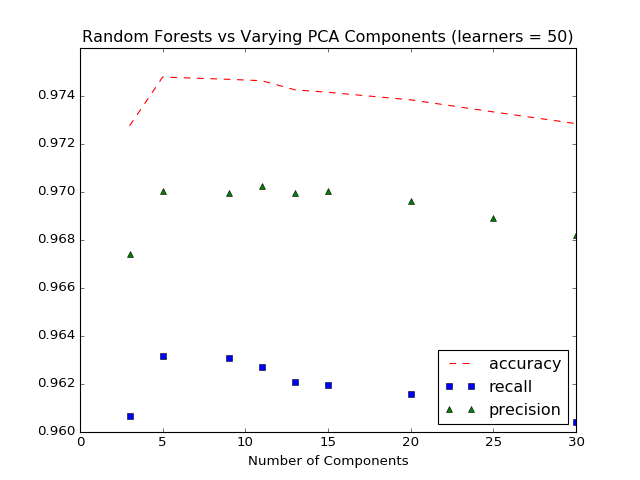

In [10]:
plt.close()
lines = plt.plot(pca_comp, pca_results['accuracy'], 'r--', pca_comp, pca_results['recall'], 'bs', pca_comp, pca_results['precision'], 'g^')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower right')
plt.title('Random Forests vs Varying PCA Components (learners = 50)')
plt.xlabel('Number of Components')
plt.show()

<IPython.core.display.Javascript object>


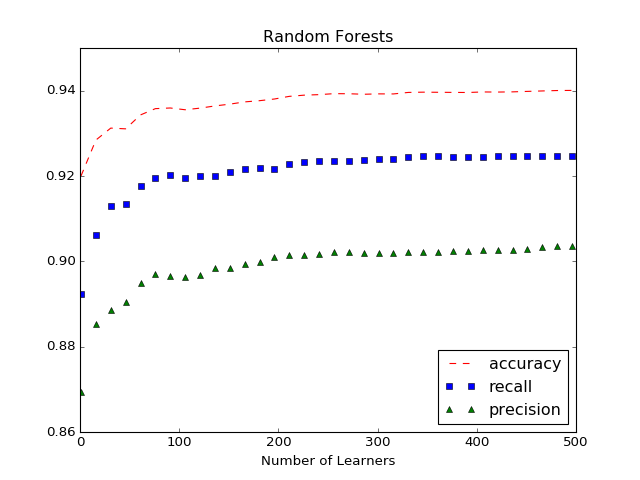

In [11]:
plt.close()
lines = plt.plot(t_list, t_results['accuracy'], 'r--', t_list, t_results['recall'], 'bs', t_list, t_results['precision'], 'g^')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower right')
plt.title('Random Forests')
plt.xlabel('Number of Learners')
plt.show()

In [16]:
# choosing best k & pca
# pca = 5, learners = 496
# pca = 5, learners = 250 (more regularized)
chosen_best_pca_comp = 5
chosen_best_learners = 250

## Confusion matrices

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<IPython.core.display.Javascript object>


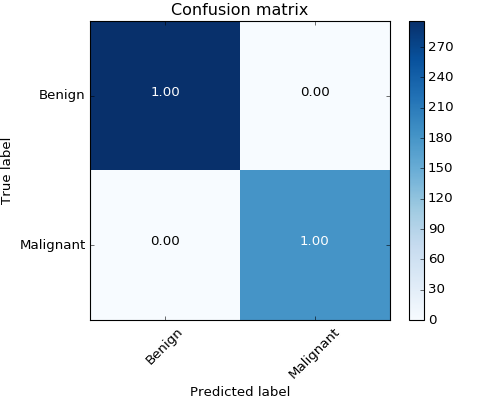

Normalized confusion matrix


In [17]:
plt.figure(figsize=(6,5))
X_reduced = my_pca(X, chosen_best_pca_comp)
mdl = Forest(n_estimators=chosen_best_learners, max_features="sqrt")
y_pred = mdl.fit(X_reduced, y).predict(X_reduced)
cm_pca = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm_pca, classes=['Benign', 'Malignant'], normalize=True)
